In [1]:
# Imports
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

# Import module from parent folder
sys.path.append("../")
from tc_potential import *

# Initialization

## Distributed Computing

In [2]:
# Enable distributed computing
dist_manager = DistributedManager()

Dask Client initialized: <Client: 'tcp://127.0.0.1:49454' processes=4 threads=12, memory=15.80 GiB>


## Global Variables

`INSTITUION_ID` specifies the institution that created the climate model.

NASA GISS in this case.

`SOURCE_ID` specifies the climate model.

NASA's GISS-E2-1-G model, for more information please see: https://data.giss.nasa.gov/modelE/cmip6/

`GRID_LABEL` specifies fhte grid option, "gn" for native grid, "gr" for re-gridded (better for comparisons across models).

`MEMBER_ID` has the format (realisation index) (initialisation index) (physics index) (forcing index) 

This is used to uniquely define each simulation of an ensemble of runs contributed by a single model. 

- The realisation index distinguishes among ensemble members which differ only in their initial conditions. 
- The initialisation index distinguishes among ensemble members which differ only in their initial procedures. 
- The physics index identifies the physics version used by the model. 
- The forcing index distinguishes ensemble members with different variants of forcing applied.

For more information about the data, please see: https://wcrp-cmip.org/cmip-data-access/

`IPCC_EXP_ID` specifies the five pathways specified in the sixth IPCC report.

In [3]:
# Specify options for the fetching of data
INSTITUTION_ID = "NASA-GISS"
SOURCE_ID = "GISS-E2-1-G"
GRID_LABEL = "gn"
MEMBER_ID = "r1i1p3f1"

# SSP pathways that appeared in the Sixth IPCC Report
EXPERIMENT_LIST = ["historical","ssp119","ssp126","ssp245","ssp370","ssp585"]

# Path to the shapefile for limiting the geography
SHP_PATH = "../../data/iho.shp"

# Fetch Data

## Display Catalog

The `CMIP6DataFetcher` class allows users to retrieve data from the CMIP6 climate models.

Using `fetch_data` and specifying `return_options_only=True` retrieves a catalog of all available datasets.

In [4]:
# Initialize data fetcher
data_fetcher = CMIP6DataFetcher()

In [5]:
# Display the catalog for our parameters
nasa_catalog = data_fetcher.fetch_data(
    institution_id=INSTITUTION_ID,
    source_id=SOURCE_ID,
    experiment_id=EXPERIMENT_LIST,
    member_id=MEMBER_ID,
    grid_label=GRID_LABEL,
    return_options_only=True           
)
display(nasa_catalog.head(4))

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p3f1,Amon,ts,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20190702
1,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p3f1,Amon,ta,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20190702
2,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p3f1,Amon,psl,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20190702
3,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p3f1,Amon,hus,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20190702


## Download Data

Specifying `return_options_only=False` retrieves the datasets as a dictionary with each entry being unique experiments.

In [6]:
nasa_ds_dict = data_fetcher.fetch_data(
    institution_id=INSTITUTION_ID,
    source_id=SOURCE_ID,
    experiment_id=EXPERIMENT_LIST,
    member_id=MEMBER_ID,
    grid_label=GRID_LABEL         
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


# Analyze Data

The `PIAnalysis` class allows users to specify a dataset and calculate potential intensity, calculate the mean of variables, and visualize the variables in a map or line plot. 

## Define Limits

Using `set_data`, users can specify limits for time, latitude/longitude, and use a geodataframe as a mask.

For this example, we use a shapefile with boundaries for the Gulf of Mexico.

In [7]:
# Use the shapefile for the Gulf of Mexico
gulf_gdf = gpd.read_file(SHP_PATH)
month_limits = [6,11]

# Specify a dictionary of PIAnalysis objects
nasa_analysis_dict = {sim_name.split(".")[3] : PIAnalysis().set_data(ds, geo_limits=gulf_gdf, month_limits=month_limits) for sim_name, ds in nasa_ds_dict.items()}

## Calculate Potential Intensity

Use `analyze_pi` to calculate the potential intensity of the specified data.

In [8]:
# Calculate potential intensity
# Access the dataset via the attribute `pi_ds`
for sim_name in EXPERIMENT_LIST:
    nasa_analysis_dict[sim_name].analyze_pi()

## Calculate Mean

Use `calculate_mean` to calculate the average of values of all available 2-dimensional variables for each month and year.

In [9]:
# Calculate the spatial mean of all 2D variables
# Access the dataframe via the attribute `mean_df`
for sim_name in EXPERIMENT_LIST:
    nasa_analysis_dict[sim_name].calculate_mean()

## Fit Trendlines

Use `fit_mean_trends` to fit the average values to a linear trendline.

In [10]:
# Calculate trends for the mean of all available variables
# Access the trends dataframe via the attribute `params_df`
# Setting `return_errors=True` will calculate residuals/error in `errors_df`
params_df_dict = {}
errors_df_dict = {}
for sim_name in EXPERIMENT_LIST:
    params_df, errors_df = nasa_analysis_dict[sim_name].fit_mean_trends(return_errors=True)
    params_df_dict[sim_name] = params_df
    errors_df_dict[sim_name] = errors_df

In [11]:
# Display the results of the trendline fitting for vmax and psl
pi_params_array = np.empty((0,6))
for sim_name in EXPERIMENT_LIST:
    params_df = params_df_dict[sim_name]
    vmax_array = params_df[params_df["variable"] == "vmax"].to_numpy()
    pmin_array = params_df[params_df["variable"] == "pmin"].to_numpy()
    pi_params_array = np.vstack([pi_params_array, 
                                 np.append([sim_name], vmax_array),
                                 np.append([sim_name], pmin_array)])
    
pd.DataFrame(pi_params_array, columns=["scenario","variable","intercept","slope","mse","rmse"]).sort_values("variable")

,scenario,variable,intercept,slope,mse,rmse
1,historical,pmin,916.893291,0.001257,483.51819,21.989047
3,ssp119,pmin,910.989327,-0.007321,476.478537,21.828388
5,ssp126,pmin,912.118089,-0.018183,538.079534,23.196541
7,ssp245,pmin,913.603075,-0.030969,516.944455,22.736413
9,ssp370,pmin,914.152486,-0.040708,529.881759,23.019161
11,ssp585,pmin,916.326988,-0.058422,572.253129,23.921813
0,historical,vmax,85.250465,-0.000548,117.026719,10.817889
2,ssp119,vmax,88.178855,0.003461,107.733007,10.379451
4,ssp126,vmax,87.686892,0.008207,121.465271,11.021128
6,ssp245,vmax,86.95981,0.014525,115.240407,10.735008


In [12]:
# Display the statistics of the residuals for vmax and psl
errors_stats_array = np.empty((0,3))
for sim_name in EXPERIMENT_LIST:
    errors_df = errors_df_dict[sim_name]
    errors_stats = np.array([errors_df["vmax_error"].mean(),
                           errors_df["vmax_error"].std()])
    errors_stats_array = np.vstack([errors_stats_array,
                                    np.append([sim_name],errors_stats)])
pd.DataFrame(errors_stats_array, columns=["scenario","mean", "std_dev"])

,scenario,mean,std_dev
0,historical,-1.7146329249806863e-14,10.823356552467176
1,ssp119,-2.5571276362529188e-14,10.389523435935486
2,ssp126,-2.1068418327770412e-14,11.03182333320422
3,ssp245,-2.5364723241668694e-14,10.745425769867786
4,ssp370,-1.4913135326127685e-14,10.837026818059437
5,ssp585,-3.70005490501432e-14,11.184446703367168


# Visualizations

## Maps

`plot_map` allows users to plot their data in a map, returning an axis object to allow further customization.

In [13]:
hist_time = ["1964-01", "2014-12"]
ssp_time = ["2015-01", "2065-12"]

hist_analysis = nasa_analysis_dict["historical"]

In [14]:
# Find the minimum and maximum variable values
min_vmax_list = [nasa_analysis_dict[sim_name].env_ds["sst"].sel(time=slice(*time)).mean(dim="time").min().compute() for sim_name, time in zip(EXPERIMENT_LIST, [hist_time] + [ssp_time]*5)]
max_vmax_list = [nasa_analysis_dict[sim_name].env_ds["sst"].sel(time=slice(*time)).mean(dim="time").max().compute() for sim_name, time in zip(EXPERIMENT_LIST, [hist_time] + [ssp_time]*5)]
vmin = min(min_vmax_list)
vmax = max(max_vmax_list)

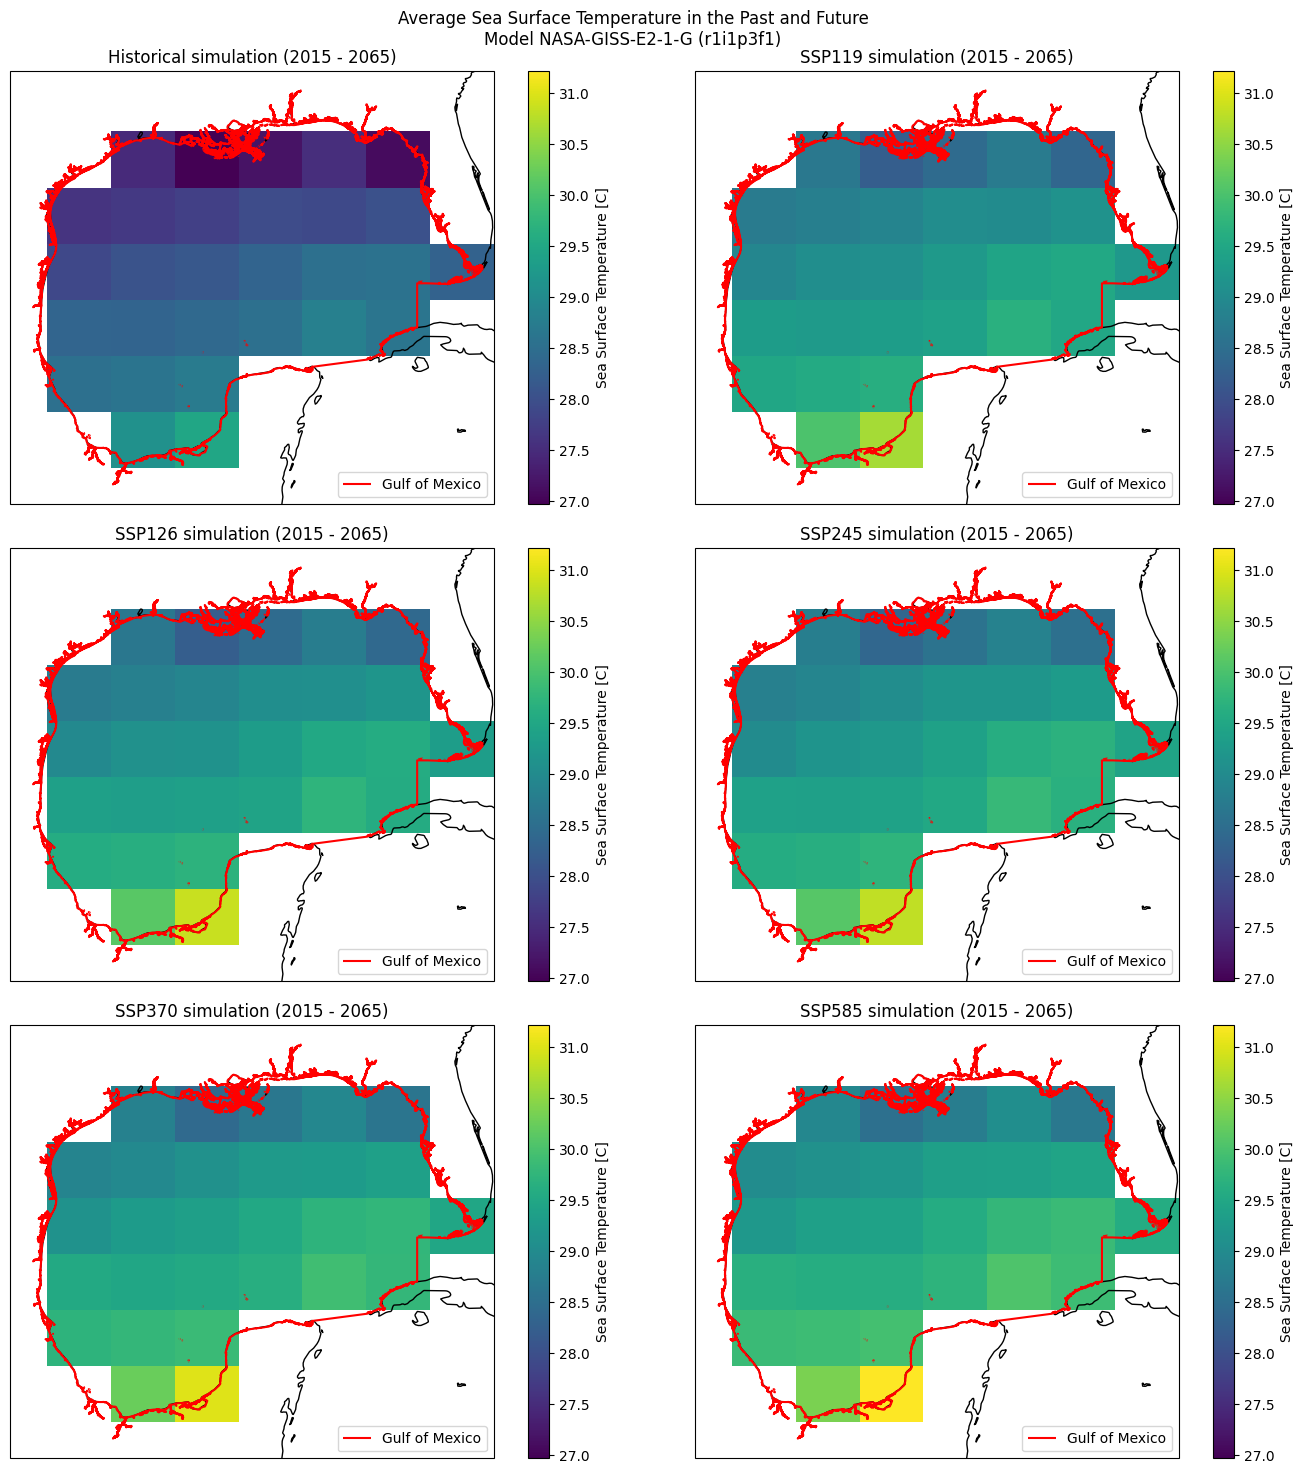

In [15]:
# Plot average sea surface temperature in all simulations 
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,5*3), subplot_kw=dict(projection=ccrs.PlateCarree()))
axes = axes.ravel()

for sim_name, ax in zip(EXPERIMENT_LIST, axes):
    sim_label = sim_name.capitalize() if sim_name == "historical" else sim_name.upper()
    time_frame = hist_time if sim_name == "historical" else ssp_time
    nasa_analysis_dict[sim_name].plot_map(
        variable="sst", 
        time=time_frame, 
        cmap_limits=[vmin, vmax], 
        plot_title=f"{sim_label} simulation ({ssp_time[0][:4]} - {ssp_time[1][:4]})", 
        ax=ax
    )
    gulf_gdf.boundary.plot(edgecolor="red", label="Gulf of Mexico", ax=ax)
    ax.legend(loc="lower right")
plt.suptitle(f"Average Sea Surface Temperature in the Past and Future\nModel NASA-GISS-E2-1-G ({MEMBER_ID})")
plt.tight_layout()

Text(0.5, 0.98, 'Average Sea Surface Temperature in the Past and Future\nModel NASA-GISS-E2-1-G (r1i1p3f1)')

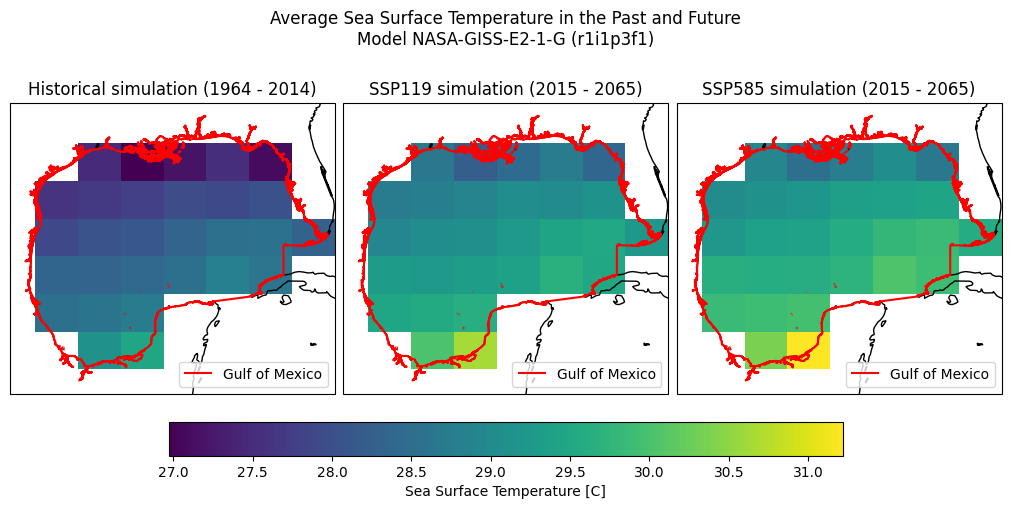

In [16]:
# Create subplots
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()), constrained_layout=True)
axes = axes.ravel()

# Set up colormap and normalization for the single shared colorbar
cmap = "viridis"
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for sim_name, sim_time, ax in zip(["historical", "ssp119", "ssp585"], [hist_time, ssp_time, ssp_time], axes):
    sim_label = sim_name.capitalize() if sim_name == "historical" else sim_name.upper()
    
    nasa_analysis_dict[sim_name].plot_map(
        variable="sst", 
        time=sim_time, 
        cmap=cmap, 
        norm=norm, 
        cmap_limits=[vmin, vmax], 
        plot_title=f"{sim_label} simulation ({sim_time[0][:4]} - {sim_time[1][:4]})", 
        ax=ax, 
        add_colorbar=False  # Ensure individual colorbars are not added
    )
    gulf_gdf.boundary.plot(edgecolor="red", label="Gulf of Mexico", ax=ax)
    ax.legend(loc="lower right")

# Add a single shared colorbar for the entire figure
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.1, pad=0.075, aspect=20)
cbar.set_label("Sea Surface Temperature [C]")

plt.suptitle(f"Average Sea Surface Temperature in the Past and Future\nModel NASA-GISS-E2-1-G ({MEMBER_ID})")

In [17]:
# Find the minimum and maximum variable values
min_vmax_list = [nasa_analysis_dict[sim_name].pi_ds["vmax"].sel(time=slice(*time)).mean(dim="time").min().compute() for sim_name, time in zip(EXPERIMENT_LIST, [hist_time] + [ssp_time]*5)]
max_vmax_list = [nasa_analysis_dict[sim_name].pi_ds["vmax"].sel(time=slice(*time)).mean(dim="time").max().compute() for sim_name, time in zip(EXPERIMENT_LIST, [hist_time] + [ssp_time]*5)]
vmin = min(min_vmax_list)
vmax = max(max_vmax_list)

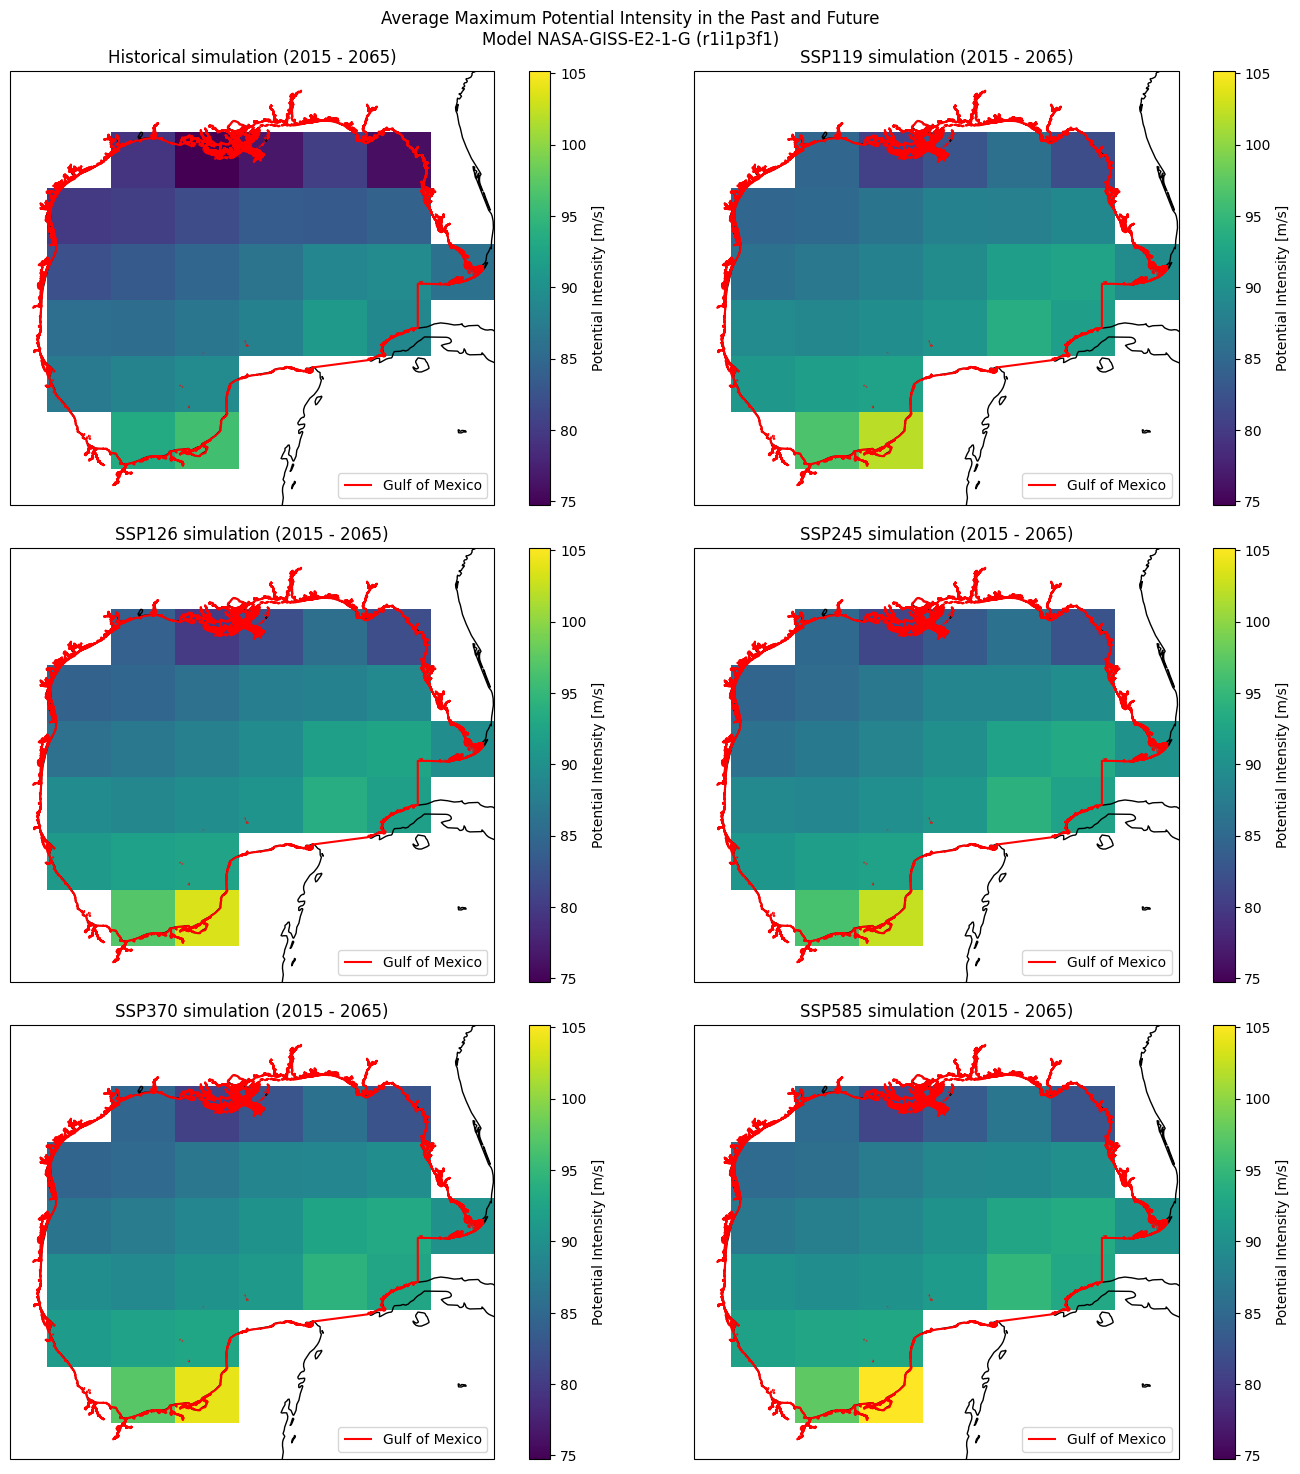

In [18]:
# Plot average potential intensity in all simulations 
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,5*3), subplot_kw=dict(projection=ccrs.PlateCarree()))
axes = axes.ravel()

for sim_name, ax in zip(EXPERIMENT_LIST, axes):
    sim_label = sim_name.capitalize() if sim_name == "historical" else sim_name.upper()
    time_frame = hist_time if sim_name == "historical" else ssp_time
    nasa_analysis_dict[sim_name].plot_map(
        variable="vmax", 
        time=time_frame, 
        cmap_limits=[vmin, vmax], 
        plot_title=f"{sim_label} simulation ({ssp_time[0][:4]} - {ssp_time[1][:4]})", 
        ax=ax
    )
    gulf_gdf.boundary.plot(edgecolor="red", label="Gulf of Mexico", ax=ax)
    ax.legend(loc="lower right")

plt.suptitle(f"Average Maximum Potential Intensity in the Past and Future\nModel NASA-GISS-E2-1-G ({MEMBER_ID})")
plt.tight_layout()

Text(0.5, 0.98, 'Average Maximum Potential Intensity in the Past and Future\nModel NASA-GISS-E2-1-G (r1i1p3f1)')

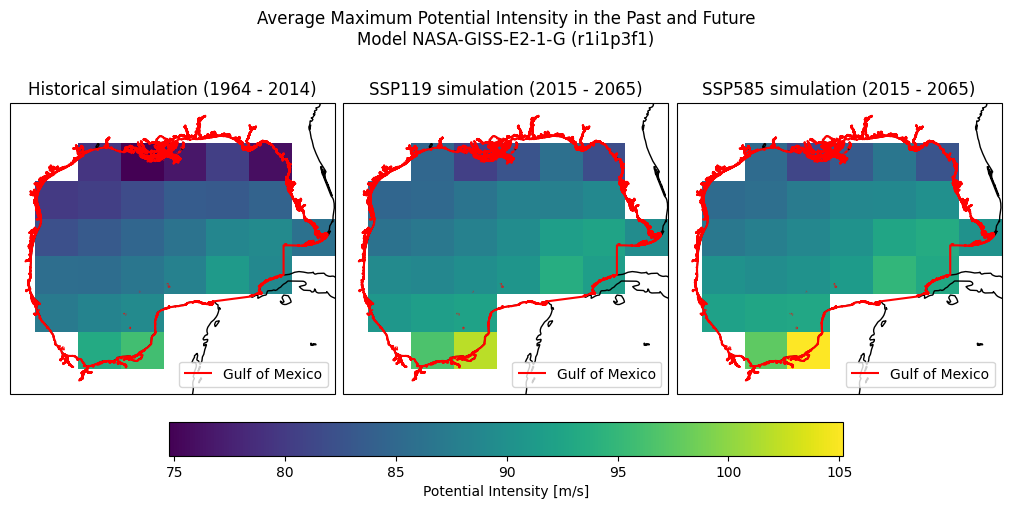

In [19]:
# Create subplots
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()), constrained_layout=True)
axes = axes.ravel()

# Set up colormap and normalization for the single shared colorbar
cmap = "viridis"
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for sim_name, sim_time, ax in zip(["historical", "ssp119", "ssp585"], [hist_time, ssp_time, ssp_time], axes):
    sim_label = sim_name.capitalize() if sim_name == "historical" else sim_name.upper()
    
    nasa_analysis_dict[sim_name].plot_map(
        variable="vmax", 
        time=sim_time, 
        cmap=cmap, 
        norm=norm, 
        cmap_limits=[vmin, vmax], 
        plot_title=f"{sim_label} simulation ({sim_time[0][:4]} - {sim_time[1][:4]})", 
        ax=ax, 
        add_colorbar=False  # Ensure individual colorbars are not added
    )
    gulf_gdf.boundary.plot(edgecolor="red", label="Gulf of Mexico", ax=ax)
    ax.legend(loc="lower right")

# Add a single shared colorbar for the entire figure
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.1, pad=0.075, aspect=20)
cbar.set_label("Potential Intensity [m/s]")

plt.suptitle(f"Average Maximum Potential Intensity in the Past and Future\nModel NASA-GISS-E2-1-G ({MEMBER_ID})")

## Line Plots

`plot_mean` allows users to plot the mean data as a line plot, returning an axis object to allow further customization.

In [20]:
# Define moving average
moving_avg = 5

In [21]:
combined_df = pd.concat([v.mean_df for v in nasa_analysis_dict.values()])
min_df = combined_df.groupby("year").min()
max_df = combined_df.groupby("year").max()

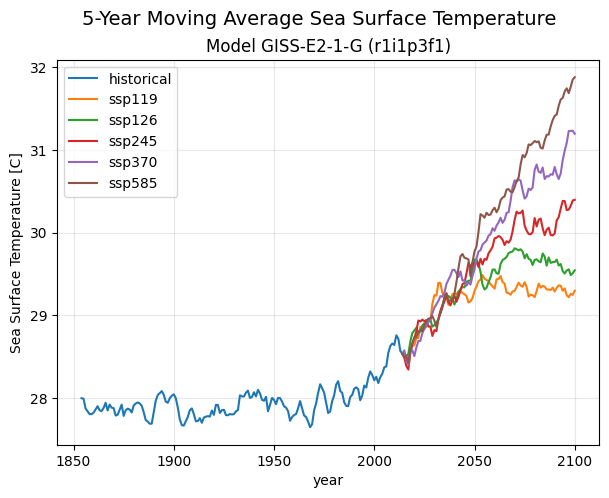

In [22]:
# Plot the average sea surface temperature
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="sst", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Sea Surface Temperature", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Sea Surface Temperature [C]")
plt.grid(alpha=0.3)

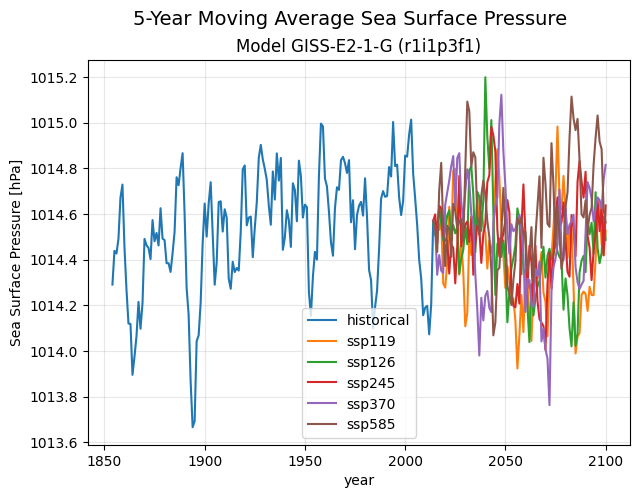

In [23]:
# Plot mean sea-level pressure
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="msl", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Sea Surface Pressure", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Sea Surface Pressure [hPa]")
plt.grid(alpha=0.3)

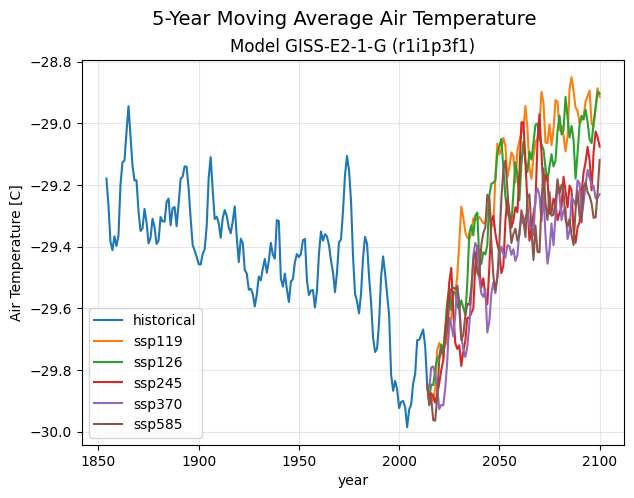

In [24]:
# Plot mean atmospheric temperature
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="t", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Air Temperature", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Air Temperature [C]")
plt.grid(alpha=0.3)

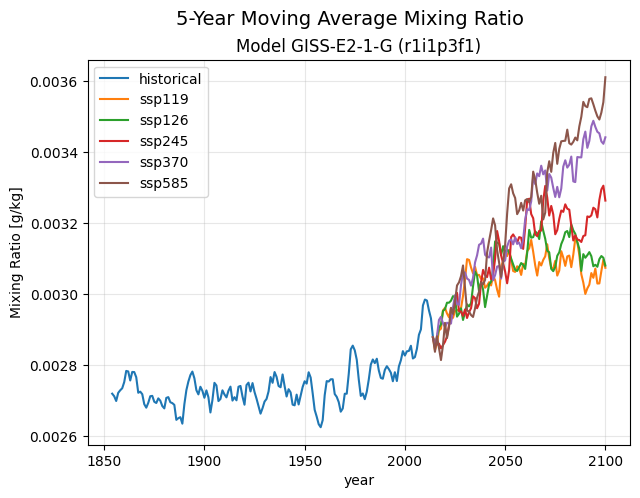

In [25]:
# Plot the mean mixing ratio
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="r", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Mixing Ratio", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Mixing Ratio [g/kg]")
plt.grid(alpha=0.3)

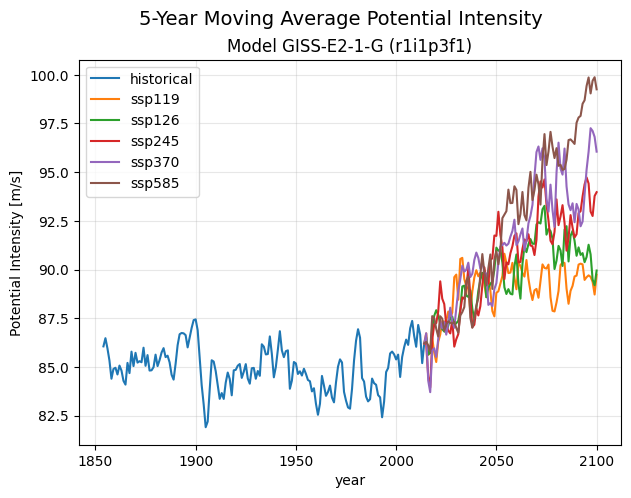

In [26]:
# Plot the mean maximum potential intensity
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="vmax", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Potential Intensity", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Potential Intensity [m/s]")
plt.grid(alpha=0.3)

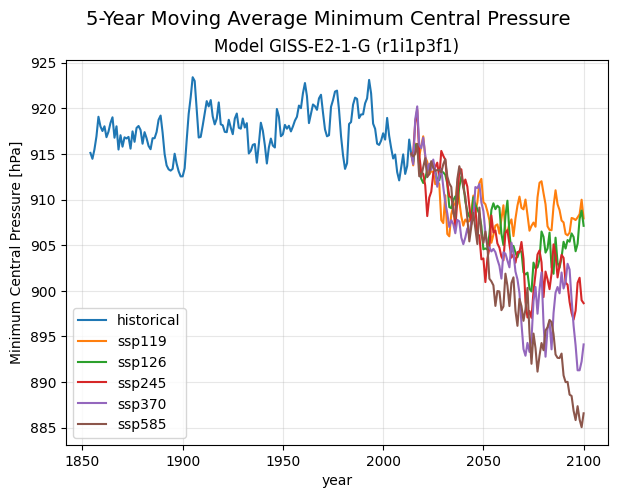

In [27]:
# Plot mean minimum central pressure
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="pmin", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Minimum Central Pressure", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Minimum Central Pressure [hPa]")
plt.grid(alpha=0.3)

## Trend Plots

`plot_mean` specifying `trendline=True` shows the trend for the specified variable.

Text(0.5, 0.98, 'Maximum Potential Intensity\nModel NASA-GISS-E2-1-G (r1i1p3f1)')

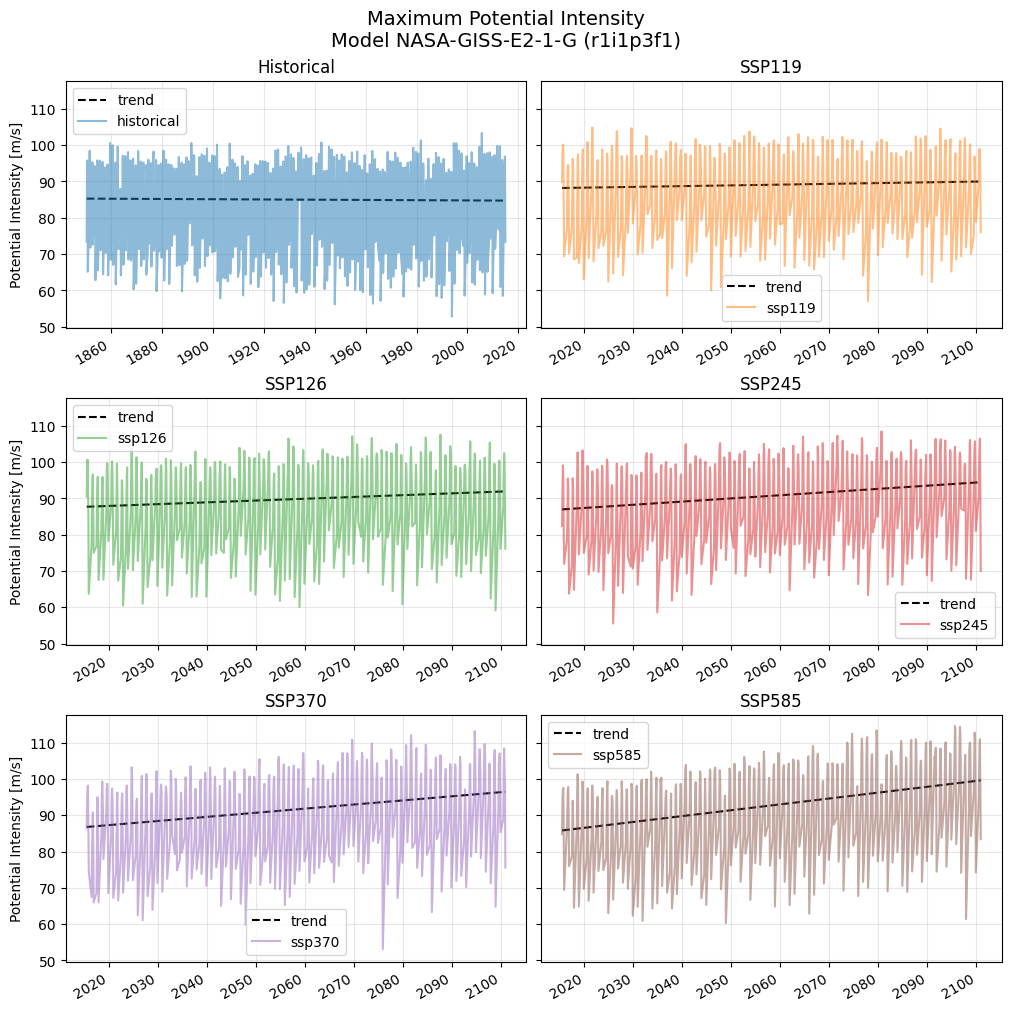

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharey=True, constrained_layout=True)
axes = axes.ravel()

for idx, (sim_name, ax) in enumerate(zip(EXPERIMENT_LIST, axes)):
    sim_label = sim_name.capitalize() if sim_name == "historical" else sim_name.upper()
    nasa_analysis_dict[sim_name].plot_mean(variable="vmax", trendline=True, ax=ax, label=sim_name, color=f"C{idx}", alpha=0.5)
    ax.legend()
    ax.set_title(f"{sim_label}")
    ax.set_ylabel("Potential Intensity [m/s]")
    ax.set_xlabel(None)
    ax.grid(alpha=0.3)

plt.suptitle(f"Maximum Potential Intensity\nModel NASA-GISS-E2-1-G ({MEMBER_ID})", fontsize=14)

Text(0.5, 0.98, 'Maximum Potential Intensity Residuals\nModel NASA-GISS-E2-1-G (r1i1p3f1)')

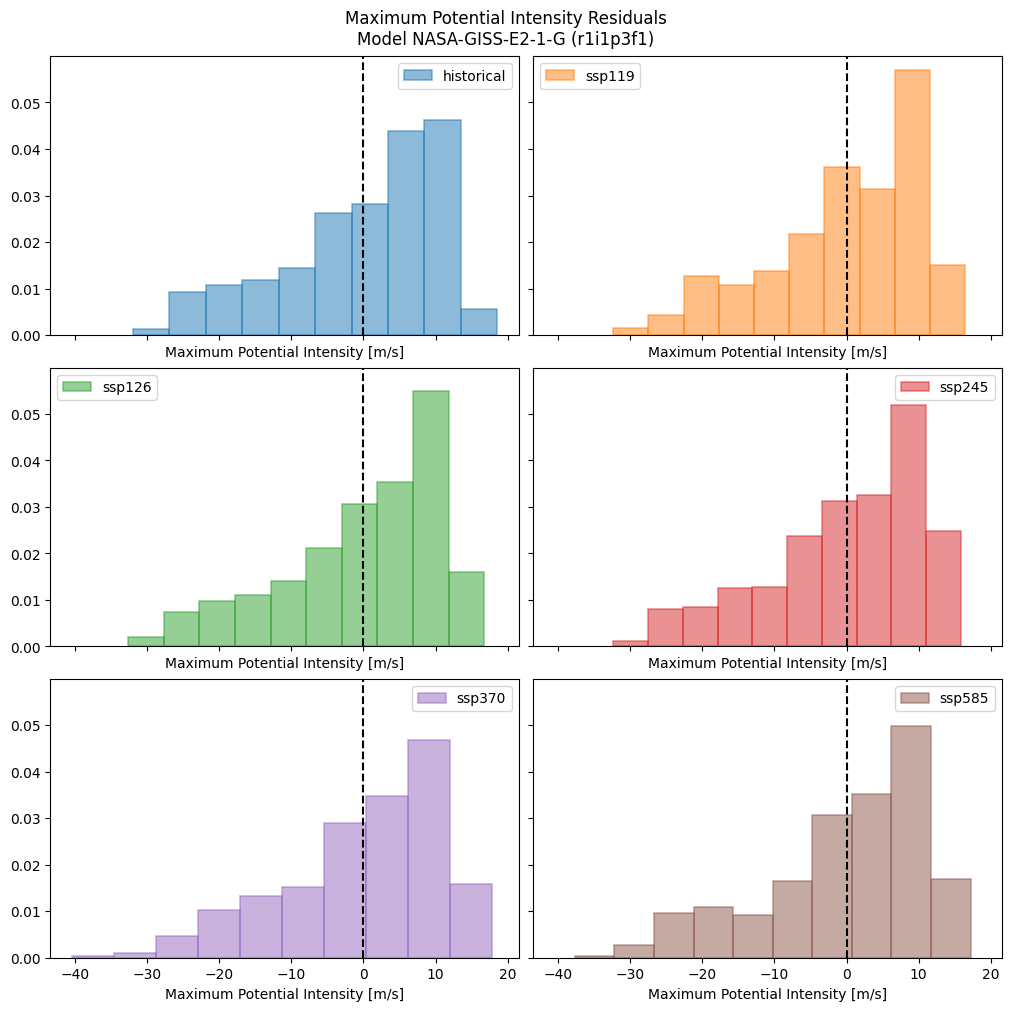

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()

for idx, (sim_name, ax) in enumerate(zip(EXPERIMENT_LIST, axes)):
    errors_df = nasa_analysis_dict[sim_name].errors_df.copy()
    ax.hist(errors_df["vmax_error"], edgecolor=f"C{idx}", linewidth=1.2, color=f"C{idx}", alpha=0.5, density=True, label=sim_name)
    ax.legend()
    ax.set_xlabel("Maximum Potential Intensity [m/s]")
    ax.axvline(0, color="k", linestyle="--")

plt.suptitle(f"Maximum Potential Intensity Residuals\nModel NASA-GISS-E2-1-G ({MEMBER_ID})")

## Supplementary Plots

We can use the matplotlib plotting functions to plot the dataframe attributes for the `PIAnalysis` class.

Text(0.5, 0.98, 'Monthly Mean Sea Surface Pressure\nModel NASA-GISS-E2-1-G (r1i1p3f1)')

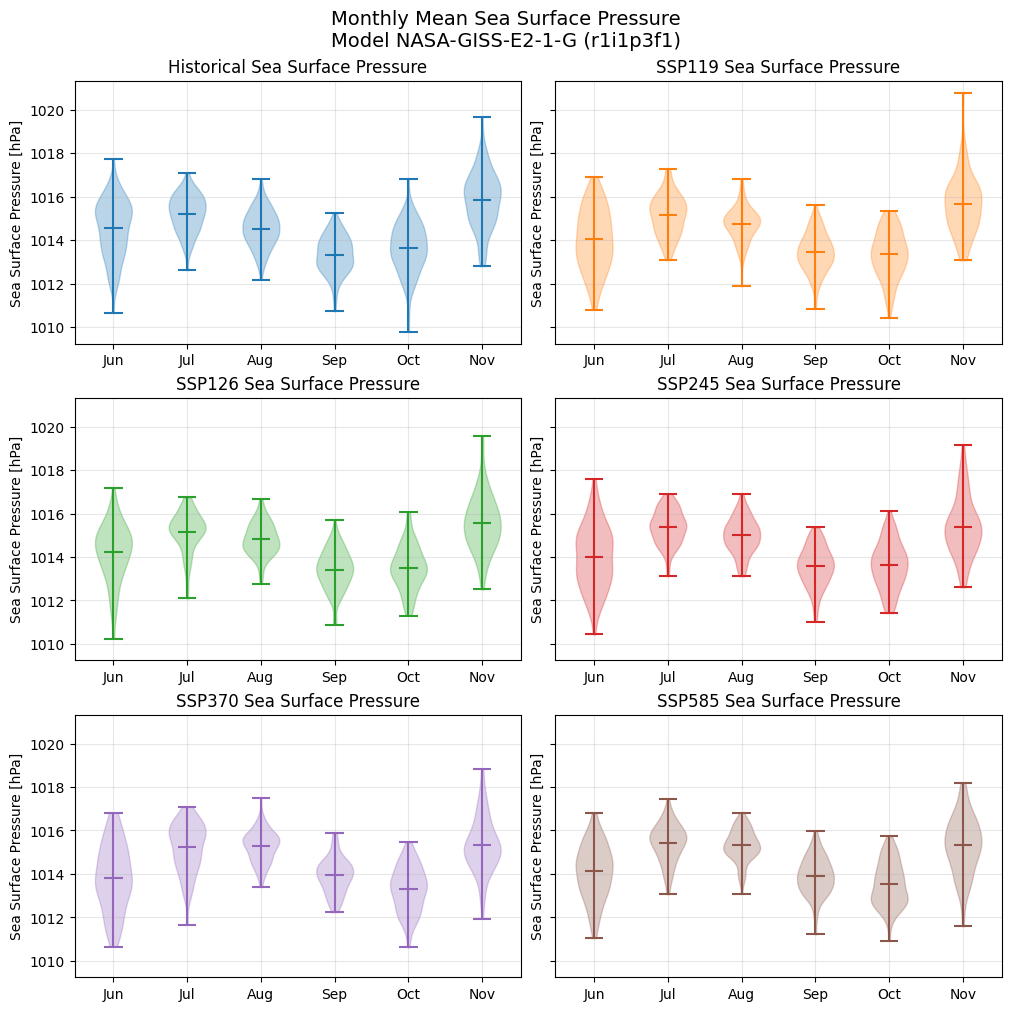

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10), sharey=True, constrained_layout=True)
axes = axes.ravel()

for idx, (sim_name, ax) in enumerate(zip(EXPERIMENT_LIST, axes)):
    sim_analysis = nasa_analysis_dict[sim_name]
    df = sim_analysis.mean_df
    grouped_df = df.groupby(df["pdtime"].dt.month)
    plot_msl = [group["msl"] for month, group in grouped_df]
    ax.set_xticks(ticks=range(1,7), labels=["Jun", "Jul", "Aug", "Sep", "Oct", "Nov"])
    violin_parts = ax.violinplot(plot_msl, showmeans=True)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = violin_parts[partname]
        vp.set_edgecolor(f"C{idx}")
    for pc in violin_parts["bodies"]:
        pc.set_color(f"C{idx}")
    sim_label = sim_name.capitalize() if sim_name == "historical" else sim_name.upper()
    ax.set_ylabel("Sea Surface Pressure [hPa]")
    ax.set_title(f"{sim_label} Sea Surface Pressure")
    ax.grid(alpha=0.3)

plt.suptitle(f"Monthly Mean Sea Surface Pressure\nModel NASA-GISS-E2-1-G ({MEMBER_ID})", fontsize=14)

# Parameter Analysis

We can vary the parameters of the pyPI module to examine how potential intensity changes as the parameters of the model change.

In this example, we will use pseudoadiabatic ascent (`ascent_flag=1`) to determine the displacement of all air parcels in the CAPE calculation. 

In [31]:
# Specify a dictionary of PIAnalysis objects
nasa_analysis_dict = {sim_name.split(".")[3] : PIAnalysis().set_data(ds, geo_limits=gulf_gdf, month_limits=month_limits) for sim_name, ds in nasa_ds_dict.items()}

## Calculate Potential Intensity

Use `analyze_pi` to calculate the potential intensity of the specified data.

In [32]:
# Calculate potential intensity
# Access the dataset via the attribute `pi_ds`
for sim_name, sim_analysis in nasa_analysis_dict.items():
    sim_analysis.analyze_pi(ascent_flag=1)

## Calculate Mean

Use `calculate_mean` to calculate the average of values of all available 2-dimensional variables for each month and year.

In [33]:
# Calculate the spatial mean of all 2D variables
# Access the dataframe via the attribute `mean_df`
for sim_name, sim_analysis in nasa_analysis_dict.items():
    sim_analysis.calculate_mean()

## Fit Trend Lines

Use `fit_mean_trends` to fit the average values to a linear trend line.

In [34]:
# Calculate trends for the mean of all available variables
# Access the trends dataframe via the attribute `params_df`
# Setting `return_errors=True` will calculate residuals/error in `errors_df`
params_df_dict = {}
for sim_name in EXPERIMENT_LIST:
    params_df, errors_df = nasa_analysis_dict[sim_name].fit_mean_trends(return_errors=True)
    params_df_dict[sim_name] = params_df

In [35]:
# Display the results of the trendline fitting for vmax and psl
pi_params_array = np.empty((0,6))
for sim_name in EXPERIMENT_LIST:
    params_df = params_df_dict[sim_name]
    vmax_array = params_df[params_df["variable"] == "vmax"].to_numpy()
    pmin_array = params_df[params_df["variable"] == "pmin"].to_numpy()
    pi_params_array = np.vstack([pi_params_array, 
                                 np.append([sim_name], vmax_array),
                                 np.append([sim_name], pmin_array)])
    
pd.DataFrame(pi_params_array, columns=["scenario","variable","intercept","slope","mse","rmse"]).sort_values("variable")

,scenario,variable,intercept,slope,mse,rmse
1,historical,pmin,871.931574,-0.000734,730.113409,27.020611
3,ssp119,pmin,860.004779,-0.010843,740.223188,27.207043
5,ssp126,pmin,861.444438,-0.026477,839.479757,28.973777
7,ssp245,pmin,863.936825,-0.048137,812.928689,28.511904
9,ssp370,pmin,864.914901,-0.065118,829.36718,28.798736
11,ssp585,pmin,867.775587,-0.08872,873.888079,29.561598
0,historical,vmax,104.359093,0.000359,126.279611,11.23742
2,ssp119,vmax,109.299589,0.004353,118.879672,10.903195
4,ssp126,vmax,108.758494,0.010291,134.31625,11.589489
6,ssp245,vmax,107.747231,0.019116,128.658342,11.342766


In [36]:
# Display the statistics of the residuals for vmax and psl
errors_stats_array = np.empty((0,3))
for sim_name in EXPERIMENT_LIST:
    errors_df = errors_df_dict[sim_name]
    errors_stats = np.array([errors_df["vmax_error"].mean(),
                           errors_df["vmax_error"].std()])
    errors_stats_array = np.vstack([errors_stats_array,
                                    np.append([sim_name],errors_stats)])
pd.DataFrame(errors_stats_array, columns=["scenario","mean", "std_dev"])

,scenario,mean,std_dev
0,historical,-1.7146329249806863e-14,10.823356552467176
1,ssp119,-2.5571276362529188e-14,10.389523435935486
2,ssp126,-2.1068418327770412e-14,11.03182333320422
3,ssp245,-2.5364723241668694e-14,10.745425769867786
4,ssp370,-1.4913135326127685e-14,10.837026818059437
5,ssp585,-3.70005490501432e-14,11.184446703367168


## Maps

`plot_map` allows users to plot their data in a map, returning an axis object to allow further customization.

In [37]:
hist_time = ["1964-01", "2014-12"]
ssp_time = ["2015-01", "2065-12"]

hist_analysis = nasa_analysis_dict["historical"]

In [38]:
# Find the minimum and maximum variable values
min_vmax_list = [analysis.pi_ds["vmax"].sel(time=slice(*ssp_time)).mean(dim="time").min().compute() for analysis in nasa_analysis_dict.values()]
max_vmax_list = [analysis.pi_ds["vmax"].sel(time=slice(*ssp_time)).mean(dim="time").max().compute() for analysis in nasa_analysis_dict.values()]
vmin = min(min_vmax_list)
vmax = max(max_vmax_list)

Text(0.5, 0.98, 'Average Maximum Potential Intensity with Pseudoadiabatic Ascent\nModel NASA-GISS-E2-1-G (r1i1p3f1)')

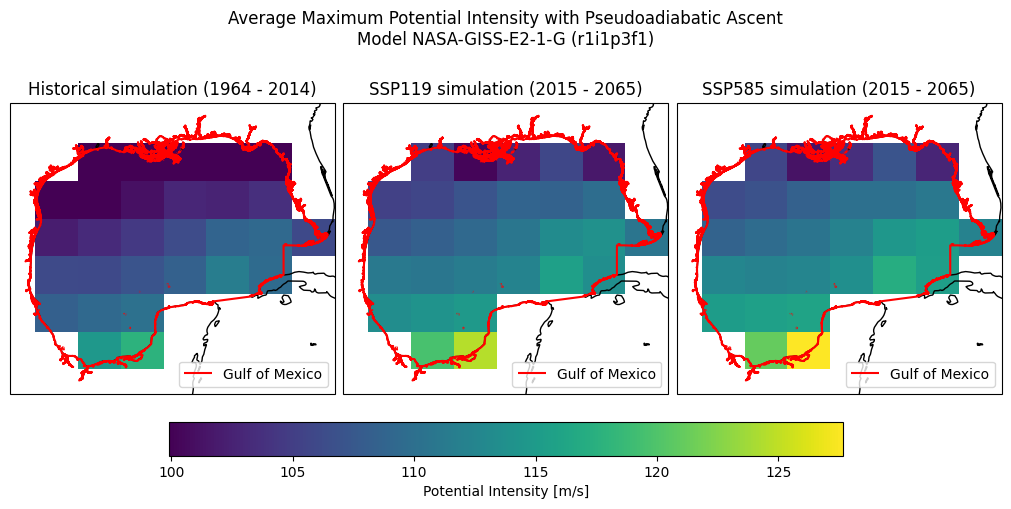

In [39]:
# Create subplots
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()), constrained_layout=True)
axes = axes.ravel()

# Set up colormap and normalization for the single shared colorbar
cmap = "viridis"
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

for sim_name, sim_time, ax in zip(["historical", "ssp119", "ssp585"], [hist_time, ssp_time, ssp_time], axes):
    sim_label = sim_name.capitalize() if sim_name == "historical" else sim_name.upper()
    
    nasa_analysis_dict[sim_name].plot_map(
        variable="vmax", 
        time=sim_time, 
        cmap=cmap, 
        norm=norm, 
        cmap_limits=[vmin, vmax], 
        plot_title=f"{sim_label} simulation ({sim_time[0][:4]} - {sim_time[1][:4]})", 
        ax=ax, 
        add_colorbar=False  # Ensure individual colorbars are not added
    )
    gulf_gdf.boundary.plot(edgecolor="red", label="Gulf of Mexico", ax=ax)
    ax.legend(loc="lower right")

# Add a single shared colorbar for the entire figure
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", fraction=0.1, pad=0.075, aspect=20)
cbar.set_label("Potential Intensity [m/s]")

plt.suptitle(f"Average Maximum Potential Intensity with Pseudoadiabatic Ascent\nModel NASA-GISS-E2-1-G ({MEMBER_ID})")

## Line Plots

`plot_mean` allows users to plot the mean data as a line plot, returning an axis object to allow further customization.

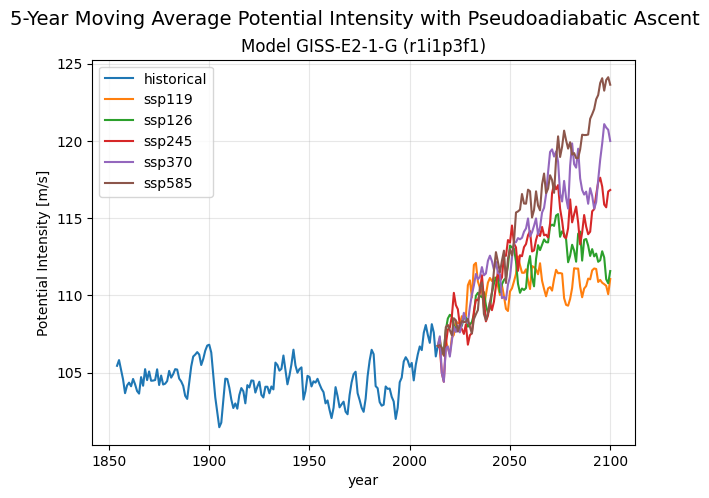

In [40]:
# Plot the mean maximum potential intensity
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="vmax", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Potential Intensity with Pseudoadiabatic Ascent", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Potential Intensity [m/s]")
plt.grid(alpha=0.3)

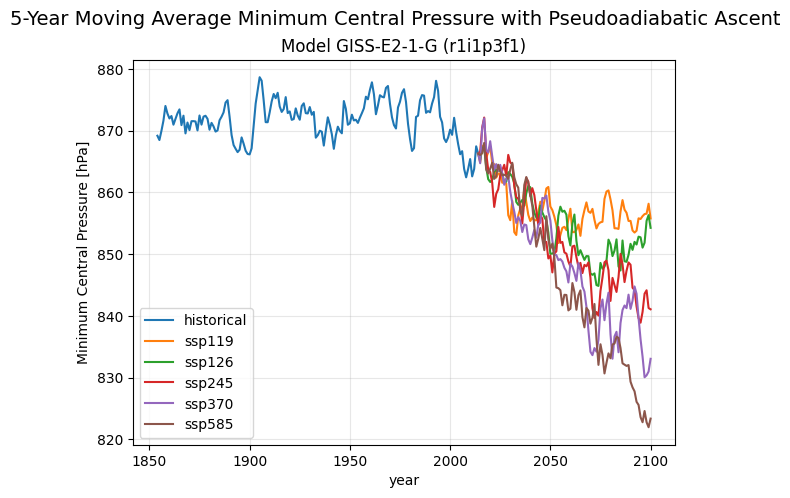

In [41]:
# Plot mean minimum central pressure
fig, ax = plt.subplots(figsize=(7,5))

for sim_name in EXPERIMENT_LIST:
    additional_df = None if sim_name == "historical" else hist_analysis.mean_df
    nasa_analysis_dict[sim_name].plot_mean(variable="pmin", yearly_window=moving_avg, additional_df=additional_df, ax=ax, label=sim_name)

plt.suptitle(f"{moving_avg}-Year Moving Average Minimum Central Pressure with Pseudoadiabatic Ascent", fontsize=14)
plt.title(f"Model {SOURCE_ID} ({MEMBER_ID})", fontsize=12)
plt.legend()
plt.ylabel("Minimum Central Pressure [hPa]")
plt.grid(alpha=0.3)